### Object Detection Finetuning

This notebook serves as an example of how to prepare and finetune Florance 2 for an object detection task. It is advisable to work your way through 01-Base_Model notebook first to understand the limitations and how Florance 2 works.

The goal is to finetune on a custom dataset, which we have previously captured and labeled (example of a 2x2 rubix cube dataset). Please find this in the sample_data folder. If you wish to use your own, change the json COCO file (ground truth) and the images provided. This notebook will be designed to start with just the contents in the raw data folder for this example. The contents in the other folders is generated as a result of this notebook.

You will notice fewer images in this folder than other fine tuning examples out there. Florence-2 excels at the ability to learn concepts with little data and a small amount of epochs compared to other deep learning options, such as Azure Custom Vison.

If you do change your data, we use a function `draw_bounding_boxes` throughout the notebook. We would advise you to alter the arguments in this function to fit the size, type, and contrast of your image dataset.

We will be finetuning using Low-Rank Adaptation (LoRa). These are some high level notes on LoRa:
- LoRA Technique: Efficiently fine-tunes large pre-trained models for specific tasks using low-rank matrix approximations.
- Rank Decomposition: Injects trainable low-rank matrices into each layer, reducing the number of parameters to update.
- Frozen Weights: Keeps original model weights frozen, training only the low-rank matrices to reduce computational overhead and memory requirements.
- Performance: Often matches or exceeds full fine-tuning despite fewer trainable parameters.
- Low-Rank Matrices: Smaller, faster to process, and require fewer computational steps. They are added to the frozen model to generate new results.
- Training Process: Frozen matrices are multiplied by low-rank matrices to generate new matrices, which are trained to find optimal weights for desired results. This process is repeated for best performance.
- Further reading: 
    - `https://medium.com/nebius/fundamentals-of-lora-and-low-rank-fine-tuning-e748f2f1255d`
    - `https://arxiv.org/pdf/2106.09685`


#### Setup model and import libraries

In [ ]:
# import libraries
import os
import json
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import AutoModelForCausalLM, AutoProcessor, get_scheduler
from tqdm import tqdm
from peft import LoraConfig, get_peft_model

# import custom libraries
from utils.image_functions import read_image
from utils.florence_functions import draw_bounding_boxes, inference_florance

# setup device and dtype if using GPU
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
print(f"device: {device} \nTORCH DTYPE: {torch_dtype}")

# setup correct file paths
data_path = "./sample_data/02-Object_Detection/"
raw_data_path = os.path.join(data_path, "raw")
processed_data_path = os.path.join(data_path, "processed")

c:\Users\henrytaylor\OneDrive - Microsoft\Desktop\Current Project\IP\Florance-2 Finetune\f2f\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device: cuda:0 
TORCH DTYPE: torch.float16


c:\Users\henrytaylor\OneDrive - Microsoft\Desktop\Current Project\IP\Florance-2 Finetune\f2f\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that i

Prompts: ['<OD>']


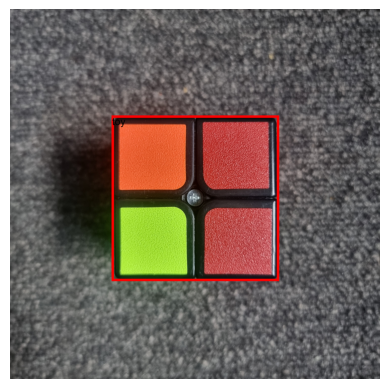

In [ ]:
# testing base florence model against a sample image
model_name = "microsoft/Florence-2-base-ft" # "microsoft/Florence-2-base" "microsoft/Florence-2-large" "microsoft/Florence-2-large-ft" 
model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch_dtype, trust_remote_code=True).to(device)
processor = AutoProcessor.from_pretrained(model_name, trust_remote_code=True)
florance2_setup = [model, processor, device, torch_dtype]

raw_image_test = os.path.join(raw_data_path, "20250424_155123.jpg") # we will use this later for an example again
img = read_image(raw_image_test)
task_input = "<OD>"
text_inputs = []
results = inference_florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=florance2_setup)  # run object detection for no specific classes
combined_results = {"bboxes": [box for result in results for box in result[task_input]["bboxes"]], "labels": [label for result in results for label in result[task_input]["labels"]]}
draw_bounding_boxes(img, combined_results, size_bb=20, size_text=80, label_bb=True, color_bb=False, text_offset=(10, 10))

#### Data Prep

Create a dataset by manually labeling your own images. This notebook expects COCO format, but if i you wish to use any alternative, then please modify the code as you see fit. You may use Azure Machine Learning labelling project or another labelling piece of software.

Some notes on formatting our ground truth:
- We pass a json object as ground truth with the following keys: image, prefix, suffix.
- There is a json object per image which is saved in a jsonl file.
- Each image must have a prefix and a suffix to finetune Florance 2. 
- The prefix is always the same for object detection: `<OD>`. The prefix is the task you want to perform.
- The suffix is the expected model response, each bounding box is described by a string with the following structure: 
    - `{class_name}<loc{x1}><loc{y1}><loc{x2}><loc{y2}>`. 
    - The values x1, y1, x2, y2 describe the bb. 
    - They should be normalised between 0 and 999 representing 0-0.999 position in the x and y co-ordinates.
    - the suffix should look like this: `product<loc_4><loc_57><loc_79><loc_109>product<loc_4><loc_109><loc_84><loc_143>...` wih every object in the class in the image

##### Bbox to Florence-2 Annotations

In [3]:
annotations_file = "2x2_rubix_COCO.json" # change as per your dataset
validation_split = 0.8 # 0.8 # if 1.0, no validation split is used
shuffle = True # shuffle the data before splitting

# Ground Truth Annotations
def convert_norm(i):
    """
    Converts normalised coordinates to florance normalised coordinates.
    [0-1] -> [0-999]
    """
    return int(i * 1000)

annotations_path = os.path.join(raw_data_path, annotations_file)
with open(annotations_path, 'r') as f:
    annotation_data = json.load(f) 
    
# create dicts for image ID to file name and category ID to name
image_id_file_name = dict([[i["id"], i['file_name']] for i in annotation_data['images']])
image_id_categories = dict([i["id"], i['name']] for i in annotation_data['categories'])
annotations = annotation_data['annotations']

# This collects all the annotations for each image in a dictionary, ready for processing to jsonl format.
annotations_formatted = {} 
for annotation in annotations: # get image ID and then file name and category name
    image_file_name = image_id_file_name[annotation["image_id"]]
    image_category_name = image_id_categories[annotation["category_id"]]

    bbox = annotation["bbox"]
    x1, y1, w_b, h_b = bbox # coco is x, y, width, height so adjust to x1, y1, x2, y2
    bbox = [convert_norm(x1), convert_norm(y1), convert_norm(x1 + w_b), convert_norm(y1 + h_b)]
    
    bboxs = annotations_formatted.get(image_file_name, {}).get("bboxs", []) # get existing
    categories = annotations_formatted.get(image_file_name, {}).get("categories", [])
    
    categories.append(image_category_name)  
    bboxs.append(bbox)
    
    annotations_formatted[image_file_name] = {"categories":categories, "bboxs":bboxs} 

# convert to jsonl format
annotations_json_strings = []
for image_file_name in annotations_formatted.keys():
        file_name_data = annotations_formatted[image_file_name]
        category_list = file_name_data["categories"]
        bbox_list = file_name_data["bboxs"]
        
        if len(category_list) != len(bbox_list):
            raise ValueError("Length of categories and bboxes do not match. Check data - there should be a 1-1 count.")
        
        suffix_lines = []
        for idx, bbox in enumerate(bbox_list):
            class_name = category_list[idx]
            x1, y1, x2, y2 = [int(i) for i in (np.array(bbox))]
            suffix_line = f"{class_name}<loc_{x1}><loc_{y1}><loc_{x2}><loc_{y2}>"
            suffix_lines.append(suffix_line)#
        
        # save in jsonl format
        json_obj = {
                "image": image_file_name,
                "prefix": "<OD>", # OD finetuning task
                "suffix": "".join(suffix_lines)
            }
        json_string = json.dumps(json_obj, separators=(',', ':'))
        annotations_json_strings.append(json_string)
        
# Save the annotations in jsonl format
# Setup train, validation, test splits as per your requirements
# Due to the small size of the dataset, we will setup a train and validation split, and use validation for testing for this toy example. 
train_output_json_path = os.path.join(processed_data_path, "train_annotations.jsonl")
val_output_json_path = os.path.join(processed_data_path, "val_annotations.jsonl")

validation_idx = int(len(annotations_json_strings) * validation_split)
if shuffle: # random
    np.random.shuffle(annotations_json_strings)
train = annotations_json_strings[:validation_idx]
val = annotations_json_strings[validation_idx:]

with open(train_output_json_path, 'w') as json_file:
    json_file.write("\n".join(train))
print(f"{len(train)} train annotations have been written to {train_output_json_path}")

with open(val_output_json_path, 'w') as json_file:
    json_file.write("\n".join(val))
print(f"{len(val)} validation annotations have been written to {val_output_json_path}")

4 train annotations have been written to ./sample_data/02-Object_Detection/processed\train_annotations.jsonl
2 validation annotations have been written to ./sample_data/02-Object_Detection/processed\val_annotations.jsonl


##### Image Resizing (if required)
Florence-2 will train quicker if images are smaller. The following provides a way to do this, if that is a requirement for your dataset.

In [4]:
# Image prepare
resize = True
scale_factor = 0.1

if resize:
    for file_name in list(image_id_file_name.values()):
        img = read_image(os.path.join(raw_data_path, file_name))
        if resize:
            new_size = (int(img.width * scale_factor), int(img.height * scale_factor))
            img = img.resize(new_size)
        img.save(os.path.join(processed_data_path, file_name))

##### Final Data Checks
Using processed data folder. This will be the data sent to Florence-2 for training.

./sample_data/02-Object_Detection/processed\20250424_155133.jpg


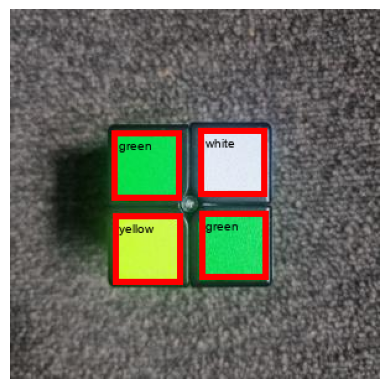

./sample_data/02-Object_Detection/processed\20250424_155154.jpg


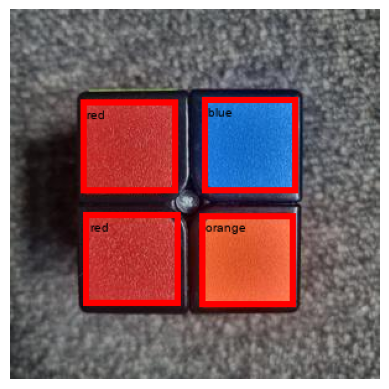

./sample_data/02-Object_Detection/processed\20250424_155123.jpg


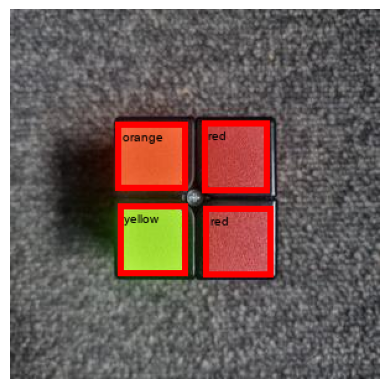

./sample_data/02-Object_Detection/processed\20250424_155139.jpg


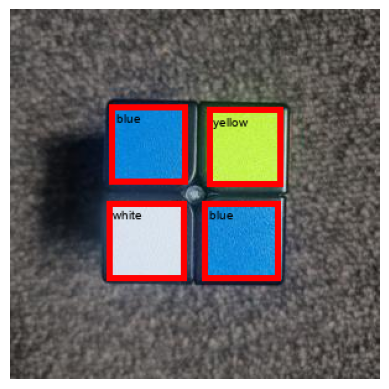

./sample_data/02-Object_Detection/processed\20250424_155149.jpg


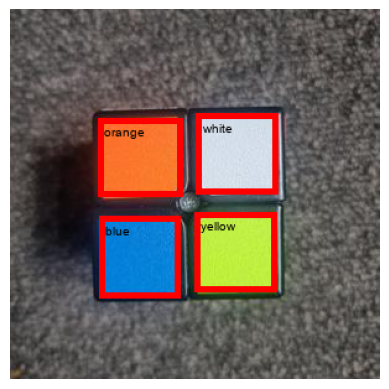

./sample_data/02-Object_Detection/processed\20250424_155129.jpg


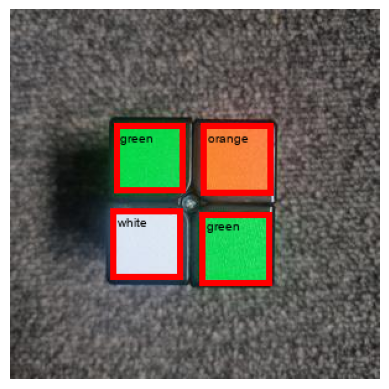

In [5]:
# check images and bounding boxes on processed images

for file_name in annotations_formatted.keys():
    img_path = os.path.join(processed_data_path, file_name)
    print(img_path)
    image = read_image(img_path)
    width, height = image.width, image.height
    bboxes = np.array(annotations_formatted[file_name]["bboxs"]) * [width/1000, height/1000, width/1000, height/1000]
    combined_results = {"bboxes": [[i[0], i[1], i[2], i[3]] for i in bboxes], "labels": annotations_formatted[file_name]["categories"]}
    draw_bounding_boxes(image, combined_results, size_bb=5, size_text=10, label_bb=True, color_bb=False)

#### Finetuning the model using custom dataset
We will create our dataset classes and our training loop and start to train with LoRa here. Dependent on your usecase you may need to adjust some LoRa parameters. I've found changing batch_size, lora_alpha, r, num epochs, and learning rate to improve finetuning performance and lora_dropout to impove overfitting. Find some more infomation on lora_alpha and r below:

- lora_alpha
    - Purpose: lora_alpha is a scaling factor for the low-rank adaptation matrices. It controls the magnitude of the adaptation applied to the pre-trained model's weights.
    - Effect:
        - Increasing lora_alpha: This amplifies the impact of the low-rank adaptation, potentially leading to more significant changes in the model's behavior. It can help the model adapt better to new tasks but might also increase the risk of overfitting.
        - Decreasing lora_alpha: This reduces the impact of the low-rank adaptation, making the changes more subtle. It can help in preventing overfitting but might limit the model's ability to adapt to new tasks.
- r
    - Purpose: r is the rank of the low-rank adaptation matrices. It determines the number of parameters added to the model for adaptation.
    - Effect:
        - Increasing r: This adds more parameters to the model, allowing for more complex adaptations. It can improve the model's performance on new tasks but also increases computational and memory requirements.
        - Decreasing r: This reduces the number of parameters, making the adaptation simpler and more efficient. It can help in reducing computational costs but might limit the model's ability to capture complex patterns in the data.

In [6]:
# create dataset and dataloader for training and validation using torch
class JSONLDataset:
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.jsonl_file_path = jsonl_file_path
        self.image_directory_path = image_directory_path
        self.entries = self._load_entries()

    def _load_entries(self):
        entries = []
        with open(self.jsonl_file_path, 'r') as file:
            for line in file:
                data = json.loads(line)
                entries.append(data)
        return entries

    def __len__(self) -> int:
        return len(self.entries)

    def __getitem__(self, idx: int):
        if idx < 0 or idx >= len(self.entries):
            raise IndexError("Index out of range")

        entry = self.entries[idx]
        image_path = os.path.join(self.image_directory_path, entry['image'])
        try:
            image = read_image(image_path)
            return (image, entry)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image file {image_path} not found.")

class DetectionDataset(Dataset):
    def __init__(self, jsonl_file_path: str, image_directory_path: str):
        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, data = self.dataset[idx]
        prefix = data['prefix']
        suffix = data['suffix']
        return prefix, suffix, image

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

train_dataset = DetectionDataset(
    jsonl_file_path = train_output_json_path,
    image_directory_path = processed_data_path
)

val_dataset = DetectionDataset(
    jsonl_file_path = val_output_json_path,
    image_directory_path = processed_data_path
)

In [7]:
# training loop
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=2,
        num_training_steps=num_training_steps,
    )

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            inputs = inputs.to(device, dtype=torch_dtype)
            
            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(
                text=answers,
                return_tensors="pt",
                padding=True,
                return_token_type_ids=False
            ).input_ids.to(device)
            
            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            train_loss += loss.item()
            
            loss.backward(); optimizer.step(); lr_scheduler.step(); optimizer.zero_grad()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")
        
        perform_validation = True
        if (perform_validation) and (len(val_loader) > 0):
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                    inputs = inputs.to(device, dtype=torch_dtype)

                    input_ids = inputs["input_ids"]
                    pixel_values = inputs["pixel_values"]
                    labels = processor.tokenizer(
                        text=answers,
                        return_tensors="pt",
                        padding=True,
                        return_token_type_ids=False
                    ).input_ids.to(device)

                    outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                    loss = outputs.loss
                    val_loss += loss.item()

                avg_val_loss = val_loss / len(val_loader)
                print(f"Average Validation Loss: {avg_val_loss}")

        save_x = 1 # save every x epochs
        if (epoch+1)%save_x==0: # save every x epochs
            output_dir = f"./model_checkpoints/object_detection/epoch_{epoch+1}"
            os.makedirs(output_dir, exist_ok=True)
            model.save_pretrained(output_dir, save_embedding_layers=True)
            processor.save_pretrained(output_dir, save_embedding_layers=True)
            print(f"Model saved at {output_dir}")
        print("\n")

In [ ]:
# Setup data, LoRA and training
# data
batch_size = 1
num_workers = 0

# lora
lora_alpha=8 # This is a scaling factor for the LoRA weights. A higher value means that the LoRA weights will have a larger impact on the model's predictions.
r=24 # This is the rank of the low-rank decomposition. A higher value means that more parameters will be added to the model for adaptation.
lora_dropout=0.05

# training
epochs = 5
learning_rate = 1e-3
reload_base_model = True # reload base model if True

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

config = LoraConfig(
    lora_alpha=lora_alpha, # This amplifies the impact of the low-rank adaptation
    r=r, # It determines the number of parameters added to the model for adaptation.   
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],
    task_type="CAUSAL_LM",
    lora_dropout=lora_dropout,
    bias="none", # none, all, lora_only
    inference_mode=False,
    use_rslora=True,
    init_lora_weights="gaussian",
)

# for multiple runs, reload base model to avoid multiple LoRA layers being added to the same model
if reload_base_model:
    model = AutoModelForCausalLM.from_pretrained(model_name, torch_dtype=torch_dtype, trust_remote_code=True).to(device)
    print("Base model reloaded.")
    
# set up lora model
peft_model = get_peft_model(model, config); peft_model.print_trainable_parameters(); print("\n---\n")

# train model with LoRA
torch.cuda.empty_cache()
train_model(train_loader, val_loader, peft_model, processor, epochs=epochs, lr=learning_rate)

Base model reloaded.


c:\Users\henrytaylor\OneDrive - Microsoft\Desktop\Current Project\IP\Florance-2 Finetune\f2f\lib\site-packages\peft\tuners\tuners_utils.py:550: UserWarning: Model with `tie_word_embeddings=True` and the tied_target_modules=['language_model.lm_head'] are part of the adapter. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. See for example https://github.com/huggingface/peft/issues/2018.
  warnings.warn(


trainable params: 5,789,784 || all params: 276,593,752 || trainable%: 2.0932

---



Training Epoch 1/6: 100%|██████████| 4/4 [00:08<00:00,  2.08s/it]


Average Training Loss: 3.6875


Validation Epoch 1/6: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it]


Average Validation Loss: 2.2822265625
Model saved at ./model_checkpoints/object_detection/epoch_1




Training Epoch 2/6: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


Average Training Loss: 1.58740234375


Validation Epoch 2/6: 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]


Average Validation Loss: 3.2001953125
Model saved at ./model_checkpoints/object_detection/epoch_2




Training Epoch 3/6: 100%|██████████| 4/4 [00:07<00:00,  1.77s/it]


Average Training Loss: 1.1123046875


Validation Epoch 3/6: 100%|██████████| 2/2 [00:05<00:00,  2.54s/it]


Average Validation Loss: 2.88671875
Model saved at ./model_checkpoints/object_detection/epoch_3




Training Epoch 4/6: 100%|██████████| 4/4 [00:07<00:00,  1.76s/it]


Average Training Loss: 0.537109375


Validation Epoch 4/6: 100%|██████████| 2/2 [00:04<00:00,  2.49s/it]


Average Validation Loss: 3.5986328125
Model saved at ./model_checkpoints/object_detection/epoch_4




Training Epoch 5/6: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Average Training Loss: 0.32470703125


Validation Epoch 5/6: 100%|██████████| 2/2 [00:05<00:00,  2.52s/it]


Average Validation Loss: 3.634765625
Model saved at ./model_checkpoints/object_detection/epoch_5




Training Epoch 6/6: 100%|██████████| 4/4 [00:07<00:00,  1.79s/it]


Average Training Loss: 0.25982666015625


Validation Epoch 6/6: 100%|██████████| 2/2 [00:05<00:00,  2.51s/it]


Average Validation Loss: 3.7275390625
Model saved at ./model_checkpoints/object_detection/epoch_6




#### Inference

In [12]:
# Load the model and processor from the saved weights
model_file_name = "epoch_5" # try load different epochs to see how the model performs

output_dir = f"./model_checkpoints/object_detection/{model_file_name}"
finetuned_model = AutoModelForCausalLM.from_pretrained(output_dir, torch_dtype=torch_dtype, trust_remote_code=True).to(device)
finetuned_processor = AutoProcessor.from_pretrained(output_dir, trust_remote_code=True)
finetuned_setup = [finetuned_model, finetuned_processor, device, torch_dtype]

Prompts: ['<OD>']


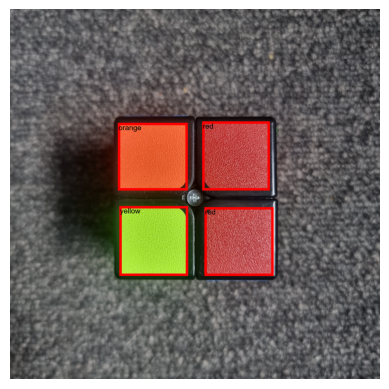

In [ ]:
img = read_image(raw_image_test) # you can also use any image here, not just the one used for training. Try use any from the inference file or take a picture of your own 2x2 rubix cube (or try a larger 3x3 cube to see if the model canextrapolate).

task_input = "<OD>"
text_inputs = []
results = inference_florance(img, task_input=task_input, text_inputs=text_inputs, florance2_setup=finetuned_setup)  # run object detection for no specific classes
combined_results = {"bboxes": [box for result in results for box in result[task_input]["bboxes"]], "labels": [label for result in results for label in result[task_input]["labels"]]}
draw_bounding_boxes(img, combined_results, size_bb=20, size_text=60, label_bb=True, color_bb=False, text_offset=(10, 10))

##### Clean Up Model Checkpoints - Optional

In [ ]:
def delete_all_content(folder_path):
    for item in os.listdir(folder_path):
        item_path = os.path.join(folder_path, item)
        if os.path.isdir(item_path):
            for root, dirs, files in os.walk(item_path, topdown=False):
                for name in files:
                    os.remove(os.path.join(root, name))
                for name in dirs:
                    os.rmdir(os.path.join(root, name))
            os.rmdir(item_path)
            print(f"Deleted folder: {item_path}")

# Example usage
clean_up_checkpoint = False # set to True to delete all content in the folder
if clean_up_checkpoint:
    delete_all_content("./model_checkpoints/")
else:
    print("No clean up performed. Set clean_up_checkpoint to True to delete all content in the folder.")

Deleted folder: ./model_checkpoints/epoch_1
Deleted folder: ./model_checkpoints/epoch_10
Deleted folder: ./model_checkpoints/epoch_11
Deleted folder: ./model_checkpoints/epoch_12
Deleted folder: ./model_checkpoints/epoch_13
Deleted folder: ./model_checkpoints/epoch_14
Deleted folder: ./model_checkpoints/epoch_15
Deleted folder: ./model_checkpoints/epoch_2
Deleted folder: ./model_checkpoints/epoch_3
Deleted folder: ./model_checkpoints/epoch_4
Deleted folder: ./model_checkpoints/epoch_5
Deleted folder: ./model_checkpoints/epoch_6
Deleted folder: ./model_checkpoints/epoch_7
Deleted folder: ./model_checkpoints/epoch_8
Deleted folder: ./model_checkpoints/epoch_9
